In [ ]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, TimeDistributed, Bidirectional
from keras.layers import LSTM, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
import codecs
import os
import time
from sklearn.model_selection import KFold
# %matplotlib inline

In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd


In [ ]:
#data = pd.read_csv(file, skiprows=1, header=None).drop(0, 1)
data = pd.read_csv('/content/texts.csv', sep=',')
column_names = ['Label', 'Text']
data.columns = column_names
data['Label'].unique()

array([  2596709,   4022849,   4748971, ..., 633093941, 624887516,
       623517704])

In [ ]:
data.head()

,Label,Text
0,2596709,поскакали??? как теперь при дерьмократии довол...
1,4022849,Кошка принесла котенка значит доверяет хозяйки...
2,4748971,Готов поработать над исследованиями за скромны...
3,7700310,мну больше питика в супермаркеты не берёт 😒 и ...
4,7700310,Занимаюсь производством значков. В письменных...


In [ ]:
data['count'] = data.groupby(['Label']).transform('count')

In [ ]:
data.head()

,Label,Text,count
0,2596709,поскакали??? как теперь при дерьмократии довол...,32
1,4022849,Кошка принесла котенка значит доверяет хозяйки...,90
2,4748971,Готов поработать над исследованиями за скромны...,34
3,7700310,мну больше питика в супермаркеты не берёт 😒 и ...,32
4,7700310,Занимаюсь производством значков. В письменных...,32


In [ ]:
data = data.loc[data['count'] > 1070]

In [ ]:
len(data.Label.value_counts())

5

In [ ]:
data.Label.value_counts()

595719538    2253
9630481      1349
7251254      1314
121274985    1228
641675418    1128
Name: Label, dtype: int64

In [ ]:
data.head()

,Label,Text,count
7932,7251254,"[id24366713|Ленар], Я все таки надеюсь что у н...",1314
7934,7251254,"[id669076531|Вилдан], Неее Зарипов это ворчи/к...",1314
7938,7251254,"Да сегодня плохо сыграл, чуть гол не привез об...",1314
7940,7251254,"[id353293172|Андрей], Но сегодня он еще часто ...",1314
7968,7251254,"[id293643093|Bek], Темная какая то история, го...",1314


In [ ]:
data.Text = data.Text.apply(str);
data['CountWords'] = data.Text.map(lambda x: len(x.split()))
print('Всего текстов:', len(data))

Всего текстов: 7272


In [ ]:
author_count_texts = data.Label.value_counts()
print('Авторов в корпусе:', len(author_count_texts))

Авторов в корпусе: 5


In [ ]:
#num_classes = 5
num_classes = len(author_count_texts)
ignore_authors = 0
texts_stat = author_count_texts[ignore_authors:ignore_authors + num_classes]

In [ ]:
#data.Label.unique()

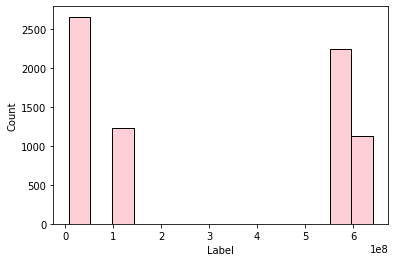

In [ ]:
import seaborn as sns 
sns_plot = sns.histplot(data.Label, color = 'pink')

In [ ]:
print('Words in texts', sum(data['CountWords']))
print('Texts in the dataset:', len(data))

Слов в текстах 199875
Текстов в корпусе: 7272


In [ ]:
names = data.Label.value_counts().index.values

lableEnc = LabelEncoder()
lableEnc.fit(names.ravel())
lables = lableEnc.transform(names).reshape((num_classes, 1))

oneHotEnc = OneHotEncoder()
oneHotEnc.fit(lables)

# получим кол-во слов для каждого текста наглядно
for author in names:
    val = lableEnc.transform([author])[0]
    data.Label.replace(to_replace=author, value=val, inplace=True)

data.head()

,Label,Text,count,CountWords
7932,0,"[id24366713|Ленар], Я все таки надеюсь что у н...",1314,15
7934,0,"[id669076531|Вилдан], Неее Зарипов это ворчи/к...",1314,6
7938,0,"Да сегодня плохо сыграл, чуть гол не привез об...",1314,23
7940,0,"[id353293172|Андрей], Но сегодня он еще часто ...",1314,15
7968,0,"[id293643093|Bek], Темная какая то история, го...",1314,13


In [ ]:

def transform_texts_to_matrix(texts, max_features):
    tokenizer = Tokenizer(split=" ", lower=True)
    if max_features != 0:
        tokenizer = Tokenizer(split=" ", lower=True, num_words=max_features)

    tokenizer.fit_on_texts(texts)
    matrix_tfidf = tokenizer.texts_to_matrix(texts=texts, mode='tfidf')
    print('Number of texts:', matrix_tfidf.shape[0])
    print('Number of tokens:', matrix_tfidf.shape[1])
    return matrix_tfidf


In [ ]:

def transform_texts_to_sequences(text):
    tokenizer = Tokenizer(split=" ", lower=True)
    tokenizer.fit_on_texts(text)
    text_sequences = tokenizer.texts_to_sequences(text)
    print('In the dictionary {} words'.format(len(tokenizer.word_index)))
    return text_sequences


In [ ]:
def count_ngramms_in_texts(texts, n, lowercase=True, remove_p=False):
    filter = '«»—!–\"−#$%&()*…,-./:;<=>?@[\\\\]^_`{|}~\\t\\n'
    vectors = []
    dict_grams = {}
    char_index = 0
    for text in texts:
        if remove_p:
            for c_filter in filter:
                text = text.replace(c_filter, '')
        if lowercase:
            text = text.lower()
        vector = []
        grams_for_text = ["".join(j) for j in zip(*[text[i:] for i in range(n)])]
        for gram in grams_for_text:
            if gram in dict_grams:
                vector.append(dict_grams[gram])
            else:
                dict_grams[gram] = char_index
                vector.append(char_index)
                char_index += 1
        vectors.append(vector)
    count_grams = len(dict_grams)
    print('Number of unique n-grams:', count_grams)
    return vectors, count_grams

In [ ]:
X, count_grams = count_ngramms_in_texts(data['Text'], 3)

Количество уникальных n-грамм: 30373


In [ ]:
def get_X_y_for_traning(X, y, num_words):
    X = keras.preprocessing.sequence.pad_sequences(X, maxlen=num_words)
    y = keras.utils.to_categorical(y, num_classes)
    print('X shape:', X.shape)
    print('y shape:', y.shape)
    return X, y

In [ ]:

num_words = 300
X, y = get_X_y_for_traning(X, data.Label, num_words)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train, test = train_test_split(X, y, test_size=0.2)



Размерность X: (7272, 100)
Размерность y: (7272, 5)


ValueError: ignored

In [ ]:
!git clone https://github.com/NVIDIA/apex

Cloning into 'apex'...
remote: Enumerating objects: 8717, done.
remote: Counting objects: 100% (1102/1102), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 8717 (delta 980), reused 857 (delta 852), pack-reused 7615
Receiving objects: 100% (8717/8717), 14.37 MiB | 13.85 MiB/s, done.
Resolving deltas: 100% (5961/5961), done.


In [ ]:
pip install -v --no-cache-dir ./apex

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [ ]:
!CUDA_LAUNCH_BLOCKING=1

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 247 kB 4.1 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 9.1 MB 41.8 MB/s 
     |████████████████████████████████| 3.3 MB 38.3 MB/s 
     |████████████████████████████████| 1.2 MB 35.0 MB/s 
     |████████████████████████████████| 3.3 MB 39.7 MB/s 
     |████████████████████████████████| 298 kB 50.3 MB/s 
     |████████████████████████████████| 1.7 MB 38.2 MB/s 
     |████████████████████████████████| 596 kB 41.9 MB/s 
     |████████████████████████████████| 895 kB 35.4 MB/s 
     |████████████████████████████████| 61 kB 381 kB/s 
     |████████████████████████████████| 180 kB 50.1 MB/s 
     |████████████████████████████████| 140 kB 36.3 MB/s 
     |████████████████████████████████| 97 kB 4.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 243 kB 49.5 MB/s 
     |████████████████████████████████| 132 kB 53.0 MB/s 
     |█████████████████

In [ ]:
def lstm_model(embeding_size):
    model = Sequential()
    model.add(Embedding(embeding_size, 500))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.3))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [ ]:
model = lstm_model(300)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 500)         250000    
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 500)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               322048    
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 573,338
Trainable params: 573,338
Non-trainable params: 0
_________________________________________________________________


In [ ]:

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
import numpy as np
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)
start = time.time()
# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = lstm_model(count_grams)
  #model.summary()


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=64,
              epochs=10,
              verbose=1)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
end = time.time()
print(end-start)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
168/168 [==============================] - 47s 243ms/step - loss: 1.7598 - accuracy: 0.3873
Epoch 2/10
168/168 [==============================] - 41s 243ms/step - loss: 0.9769 - accuracy: 0.6570
Epoch 3/10
168/168 [==============================] - 40s 237ms/step - loss: 0.5832 - accuracy: 0.7909
Epoch 4/10
168/168 [==============================] - 40s 237ms/step - loss: 0.3815 - accuracy: 0.8644
Epoch 5/10
168/168 [==============================] - 40s 238ms/step - loss: 0.2707 - accuracy: 0.9045
Epoch 6/10
168/168 [==============================] - 40s 239ms/step - loss: 0.1946 - accuracy: 0.9317
Epoch 7/10
168/168 [==============================] - 41s 242ms/step - loss: 0.1339 - accuracy: 0.9543
Epoch 8/10
168/168 [==============================] - 40s 239ms/step - loss: 0.1081 - accuracy: 0.9655
Epoch 9/10
168/168 [==============================] - 40s 241ms/step - loss: 0.

KeyboardInterrupt: ignored

In [ ]:
import statistics

print(statistics.mean(acc_per_fold))
print(statistics.stdev(acc_per_fold))

32.089999999999996
3.635458094319827


In [ ]:
def bi_lstm(embeding_size):
    model = Sequential()
    model.add(Embedding(embeding_size, 500))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(20, dropout=0.3, recurrent_dropout=0.3)))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
from sklearn.model_selection import KFold
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
import numpy as np
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = bi_lstm(count_grams)
  #model.summary()


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=128,
              epochs=10,
              verbose=1)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
84/84 [==============================] - 49s 501ms/step - loss: 2.0425 - accuracy: 0.2915
Epoch 2/10
84/84 [==============================] - 43s 507ms/step - loss: 1.2726 - accuracy: 0.6240
Epoch 3/10
84/84 [==============================] - 42s 502ms/step - loss: 0.7703 - accuracy: 0.7700
Epoch 4/10
84/84 [==============================] - 42s 500ms/step - loss: 0.5073 - accuracy: 0.8459
Epoch 5/10
84/84 [==============================] - 42s 502ms/step - loss: 0.3577 - accuracy: 0.8975
Epoch 6/10
84/84 [==============================] - 42s 503ms/step - loss: 0.2649 - accuracy: 0.9260
Epoch 7/10
84/84 [==============================] - 42s 505ms/step - loss: 0.1995 - accuracy: 0.9470
Epoch 8/10
84/84 [==============================] - 43s 508ms/step - loss: 0.1513 - accuracy: 0.9598
Epoch 9/10
84/84 [==============================] - 43s 510ms/step - loss: 0.1205 - accuracy: 0

KeyboardInterrupt: ignored

In [ ]:
import statistics

print(statistics.mean(acc_per_fold))
print(statistics.stdev(acc_per_fold))

In [ ]:
def conv_conv_model(embeding_size):
    model = Sequential()
    model.add(Embedding(embeding_size, 500))
    model.add(SpatialDropout1D(0.5))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
from sklearn.model_selection import KFold
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
import numpy as np
# Define the K-fold Cross Validator

kfold = KFold(n_splits=10, shuffle=True)
start = time.time()
# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = conv_conv_model(count_grams)
  #model.summary()

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=32,
              epochs=10,
              verbose=1)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

end = time.time()
print(end-start)




NameError: ignored

In [ ]:
from statistics import mean
import statistics

print(mean(acc_per_fold))
print(statistics.stdev(acc_per_fold))

In [ ]:
def conv_lstm_model(embeding_size):
    model = Sequential()
    model.add(Embedding(embeding_size, 550))
    model.add(SpatialDropout1D(0.5))
    model.add(Conv1D(filters=512, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D())
    model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [ ]:
model = conv_lstm_model(count_grams)
start = time.time()
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = conv_lstm_model(count_grams)
  #model.summary()


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=64,
              epochs=10,
              verbose=1)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1


end = time.time()
print(end-start)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
103/103 [==============================] - 39s 338ms/step - loss: 1.3808 - accuracy: 0.4175
Epoch 2/10
103/103 [==============================] - 35s 338ms/step - loss: 0.6944 - accuracy: 0.7532
Epoch 3/10
103/103 [==============================] - 35s 339ms/step - loss: 0.4155 - accuracy: 0.8640
Epoch 4/10
103/103 [==============================] - 35s 335ms/step - loss: 0.2795 - accuracy: 0.9075
Epoch 5/10
103/103 [==============================] - 35s 337ms/step - loss: 0.2176 - accuracy: 0.9294
Epoch 6/10
103/103 [==============================] - 35s 340ms/step - loss: 0.1694 - accuracy: 0.9438
Epoch 7/10
103/103 [==============================] - 35s 337ms/step - loss: 0.1417 - accuracy: 0.9528
Epoch 8/10
103/103 [==============================] - 35s 339ms/step - loss: 0.1198 - accuracy: 0.9616
Epoch 9/10
103/103 [==============================] - 35s 338ms/step - loss: 0.

In [ ]:
import statistics
print(statistics.mean(acc_per_fold))
print(statistics.stdev(acc_per_fold))

86.96419060230255
2.165747039896887


In [ ]:
def lstm_conv_model(embeding_size):
    model = Sequential()
    model.add(Embedding(embeding_size, 500))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
    model.add(Conv1D(filters=512, kernel_size=3, activation='sigmoid'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:

model = lstm_conv_model(count_grams)
start = time.time()
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = lstm_conv_model(count_grams)
  #model.summary()

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=64,
              epochs=10,
              verbose=1)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
end = time.time()
print(end-start)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
103/103 [==============================] - 63s 584ms/step - loss: 1.2447 - accuracy: 0.4759
Epoch 2/10
103/103 [==============================] - 61s 594ms/step - loss: 0.5072 - accuracy: 0.8258
Epoch 3/10
103/103 [==============================] - 60s 585ms/step - loss: 0.2766 - accuracy: 0.9138
Epoch 4/10
103/103 [==============================] - 60s 584ms/step - loss: 0.2005 - accuracy: 0.9361
Epoch 5/10
103/103 [==============================] - 61s 590ms/step - loss: 0.1448 - accuracy: 0.9522
Epoch 6/10
103/103 [==============================] - 60s 583ms/step - loss: 0.1094 - accuracy: 0.9650
Epoch 7/10
103/103 [==============================] - 61s 590ms/step - loss: 0.0924 - accuracy: 0.9751
Epoch 8/10
103/103 [==============================] - 61s 591ms/step - loss: 0.0758 - accuracy: 0.9774
Epoch 9/10
103/103 [==============================] - 60s 584ms/step - loss: 0.

KeyboardInterrupt: ignored

In [ ]:
print(statistics.mean(acc_per_fold))
print(statistics.stdev(acc_per_fold))

90.21150588989258
1.0467949304696773


In [ ]:
def conv_model(embeding_size):
    model = Sequential()
    model.add(Embedding(embeding_size, 500))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = conv_model(count_grams)
start = time.time()
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = conv_model(count_grams)
  #model.summary()


  # Generate a print
  print('------------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=64,
              epochs=10,
              verbose=1)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
end = time.time()
print(end-start)

In [ ]:
import statistics
print(statistics.mean(acc_per_fold))
print(statistics.stdev(acc_per_fold))